# 원 출처
이 자료는 원 출처로부터 받은 ipynb파일을 변형시킨 파일입니다.

* [동영상:코로나 바이러스 확진자 수 예측하기](https://www.youtube.com/watch?v=y-oJYSoUNyI)
* [깃허브 소스코드 및 간략 설명](https://github.com/kairess/corona-virus-prediction)



---

* [설명 참고 블로그](https://jaejune0625.tistory.com/56)

# 라이브러리 불러오기

In [22]:
import pandas as pd
import plotly.graph_objs as go#깔끔한 그래프 라이브러리들 중 하나인 plotly
import plotly.offline as py#plotly를 오프라인에서 사용 가능하도록 함.(원래는 온라인에서 html로 그래프 출력)
from fbprophet import Prophet#페이스북에서 제공하는 예측 모델 라이브러리인 Prophet을 import함
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

import matplotlib.pyplot as plt

import numpy as np

# 데이터셋 로드

error_bad_line 옵션을 False로 하면 오류가 발생한 줄을 빼고 처리함. 자세한 내용은 [링크](https://m.blog.naver.com/wideeyed/221743008492)참조

데이터셋 출처:[바로가기](https://github.com/jooeungen/coronaboard_kr)
* [kr_daily.csv](https://github.com/jooeungen/coronaboard_kr/blob/master/kr_daily.csv)를 사용했음
*이 레포지토리는 질병관리본부의 확진자 발표 후 매일 오전 11시에 업데이트됨

In [23]:
#원래 링크는 데이터의 정확도가 떨어지는 것 같아서 더 낫다고 판단되는 링크로 교체했습니다

'''
주의: 본 사이트에서 제공하는 통계 수치는 대한민국 질병관리 본부 및 세계 각국 관련 부처 보도자료, 국내외 언론 기사 등을 토대로 업데이트 되지만, 
개인이 취합한 내용이므로 수치의 정확성에 대해 책임질 수 없으며, 공식적인 근거 자료로 활용될 수 없습니다. 
본 사이트에서 제공하는 내용의 인용과 사용에 대한 책임은 전적으로 인용자 및 사용자에게 있음을 알립니다.
'''

url = 'https://raw.githubusercontent.com/jooeungen/coronaboard_kr/master/kr_daily.csv'
data = pd.read_csv(url, sep=',', error_bad_lines=False) #error_bad_line 옵션을 False로 하면 오류가 발생한 줄을 빼고 처리함.

#개인이 정부 공식 코로나 확진자 집계 발표 사이트를 바탕으로 데이터를 축적한 csv 파일입니다.
#지금까지는 매일매일 업데이트 되고 있습니다.

# Understanding the structure of the data set
# Data Set의 구조 파악

data.tail(10)

,date,confirmed,death,released,tested,negative,critical
479,20210514,130379,1893,120395,9281291,9055704,153.0
480,20210515,131060,1896,121282,9319094,9088818,150.0
481,20210516,131670,1900,121764,9336614,9103281,150.0
482,20210517,132289,1903,122163,9353300,9119207,151.0
483,20210518,132817,1904,122631,9395004,9158774,156.0
484,20210519,133471,1912,123237,9428644,9190679,148.0
485,20210520,134117,1916,123659,9447358,9204368,151.0
486,20210521,134678,1922,124158,9487108,9238286,147.0
487,20210522,135344,1926,125032,9520966,9268064,150.0
488,20210523,135929,1931,125881,9536299,9278135,149.0


###컬럼 설명
* confirmed:누적 코로나 확진자 수

* death:누적 코로나 확진 판정 후 사망자 수

* released:누적 격리해제된 사람들 수

* tested:누적 코로나 총 검사자 수*

* negative:누적 음성판정된 사람들 수

* critical:치명률

*총 검사자 = 검사 중 + 결과 음성 + 결과 확진

# 단순화(간략화) 작업

In [24]:
# 한국의 확진자 시계열 데이터프레임를 확인합니다

df_korea=data
df_korea['date']= df_korea['date'].astype('str')
df_korea['date']=pd.to_datetime(df_korea['date'])

 
df_korea.tail(10)

,date,confirmed,death,released,tested,negative,critical
479,2021-05-14,130379,1893,120395,9281291,9055704,153.0
480,2021-05-15,131060,1896,121282,9319094,9088818,150.0
481,2021-05-16,131670,1900,121764,9336614,9103281,150.0
482,2021-05-17,132289,1903,122163,9353300,9119207,151.0
483,2021-05-18,132817,1904,122631,9395004,9158774,156.0
484,2021-05-19,133471,1912,123237,9428644,9190679,148.0
485,2021-05-20,134117,1916,123659,9447358,9204368,151.0
486,2021-05-21,134678,1922,124158,9487108,9238286,147.0
487,2021-05-22,135344,1926,125032,9520966,9268064,150.0
488,2021-05-23,135929,1931,125881,9536299,9278135,149.0


In [25]:
#일일확진자 및 사망자 완치자 검사자 column생성
for df_korea_column in ["death","released","tested","confirmed"]:#사망자,격리해제자,검사자,확진자
  new_daily_column='daily_'+df_korea_column
  df_korea[new_daily_column]=df_korea[df_korea_column][:]#일단 한번 프레임을 선언하고 만들어줘야함
  for i in range(len(df_korea)):
    if i==0:
      df_korea.at[i,new_daily_column]=df_korea[df_korea_column][i]#첫번째 값을 계산할 땐 전날값이 없으므로(0이므로) 오늘값이 증가량임
    else:
      df_korea.at[i,new_daily_column]=df_korea[df_korea_column][i]-df_korea[df_korea_column][i-1]#오늘값-전날값=증가량

In [26]:
df_korea.tail()

,date,confirmed,death,released,tested,negative,critical,daily_death,daily_released,daily_tested,daily_confirmed
484,2021-05-19,133471,1912,123237,9428644,9190679,148.0,8,606,33640,654
485,2021-05-20,134117,1916,123659,9447358,9204368,151.0,4,422,18714,646
486,2021-05-21,134678,1922,124158,9487108,9238286,147.0,6,499,39750,561
487,2021-05-22,135344,1926,125032,9520966,9268064,150.0,4,874,33858,666
488,2021-05-23,135929,1931,125881,9536299,9278135,149.0,5,849,15333,585


# 그래프 그리기

In [27]:
# Plot Korean COVID19 confirmed cases.
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다.
 
fig = go.Figure()
 
fig.add_trace( 
    go.Scatter(
        x=df_korea.date,
        y=df_korea.daily_confirmed,
        name='Confirmed in Korea'
    )
)
 
fig
#코로나 일일확진자수 그래프

In [28]:
df_korea.tail()

,date,confirmed,death,released,tested,negative,critical,daily_death,daily_released,daily_tested,daily_confirmed
484,2021-05-19,133471,1912,123237,9428644,9190679,148.0,8,606,33640,654
485,2021-05-20,134117,1916,123659,9447358,9204368,151.0,4,422,18714,646
486,2021-05-21,134678,1922,124158,9487108,9238286,147.0,6,499,39750,561
487,2021-05-22,135344,1926,125032,9520966,9268064,150.0,4,874,33858,666
488,2021-05-23,135929,1931,125881,9536299,9278135,149.0,5,849,15333,585


# 페이스북에서 만든 Prophet라는 시계열 예측모델 사용
[Prophet 공식 홈페이지](https://facebook.github.io/prophet/)

<참고자료>

[Prophet 모델에 대한 간략 설명](https://hyperconnect.github.io/2020/03/09/prophet-package.html)

[Prophet을 이용한 주가 예측](https://skyeong.net/290)



In [29]:
# Make dataframe for Facebook Prophet prediction model.
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다.
df_prophet = df_korea.rename(columns={
    'date': 'ds',#날짜(ds)
    'daily_confirmed': 'y'#일일 확진자수를 y로 설정
})
#column명을 date에서 ds로, daily_confirmed에서 y로 바꿔줌 #.rename이 각 컬럼명을 일일히 바꿔줄 수 있는 함수임)
df_prophet.tail(10)

,ds,confirmed,death,released,tested,negative,critical,daily_death,daily_released,daily_tested,y
479,2021-05-14,130379,1893,120395,9281291,9055704,153.0,2,489,40138,747
480,2021-05-15,131060,1896,121282,9319094,9088818,150.0,3,887,37803,681
481,2021-05-16,131670,1900,121764,9336614,9103281,150.0,4,482,17520,610
482,2021-05-17,132289,1903,122163,9353300,9119207,151.0,3,399,16686,619
483,2021-05-18,132817,1904,122631,9395004,9158774,156.0,1,468,41704,528
484,2021-05-19,133471,1912,123237,9428644,9190679,148.0,8,606,33640,654
485,2021-05-20,134117,1916,123659,9447358,9204368,151.0,4,422,18714,646
486,2021-05-21,134678,1922,124158,9487108,9238286,147.0,6,499,39750,561
487,2021-05-22,135344,1926,125032,9520966,9268064,150.0,4,874,33858,666
488,2021-05-23,135929,1931,125881,9536299,9278135,149.0,5,849,15333,585


# 모델 만들기

# Add changepoints to Make More Flexible
# 예측을 더 유연하게 하기 위해 변곡점(changepoint) 추가
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [59]:
#주말 데이터 프레임 만들기
weekends = pd.DataFrame({
    'holiday': 'weekends',
    'ds': pd.concat([
        pd.Series(pd.date_range('2020-01-27',df_prophet.at[len(df_prophet)-1,'ds'].date(), freq='7D')),
        pd.Series(pd.date_range('2020-01-26',df_prophet.at[len(df_prophet)-1,'ds'].date(), freq='7D'))
        ]).sort_index(axis=0),
    'lower_window': 0,
    'upper_window': 1,
    })
weekends

,holiday,ds,lower_window,upper_window
0,weekends,2020-01-27,0,1
0,weekends,2020-01-26,0,1
1,weekends,2020-02-02,0,1
1,weekends,2020-02-03,0,1
2,weekends,2020-02-09,0,1
...,...,...,...,...
67,weekends,2021-05-10,0,1
67,weekends,2021-05-09,0,1
68,weekends,2021-05-17,0,1
68,weekends,2021-05-16,0,1


In [45]:
# Make Prophet model including daily seasonality
# Prophet에서 고려할 일일 계절성을 선택해서 모델을 만듭니다

m = Prophet(
    changepoint_prior_scale=0.5, #더 증가할 수록 유연하게 변함.
    changepoint_range=0.95,
    n_changepoints=30,

    yearly_seasonality=False,#연별 계절성
    weekly_seasonality=5.4, #주별 계절성
    daily_seasonality=8, #일별 계절성

    uncertainty_samples=1000,

    holidays=weekends,
    holidays_prior_scale=15,
    seasonality_mode="multiplicative"#additve와 multiplicative 모드가 있음
)
m.add_seasonality(name='monthly_seasonality', period=30.5, fourier_order=3)#월별 계절성

    
m.add_country_holidays(country_name='Korea')
m.upper_window=1.5 #holiday 이후 며칠동안 영향을 미치는가?
#m.lower_window=1 #holiday 전 며칠동안 영향을 미치는가?


#df_prophet를 예측모델에 피팅하기
m.fit(df_prophet)
##예측모델 만들기
future = m.make_future_dataframe(periods=7)#periods는 예측할 날짜의 수를 의미함
forecast = m.predict(future)#future의 데이터 프레임으로 예측하기
 
fig = plot_plotly(m, forecast,plot_cap=True,figsize=(1000, 800),trend=True, changepoints=False, xlabel='ds(시간)', ylabel='y(확진자 증가량)')#예측한 데이터 프레임을 그래프로 변환하기
py.iplot(fig)#그래프로 나타내기
#파란색 선이 예측값이고 하늘색 부분은 예측의 오차범위(?), 검정색 점 부분은 실제 데이터임
#하늘 색 부분이 정확히 뭔지는 추가 검색이 필요함

In [46]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Lunar New Year's Day,Alternative holiday of Lunar New Year's Day_lower,Alternative holiday of Lunar New Year's Day_upper,Alternative public holiday,...,weekends,weekends_lower,weekends_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
505,2021-06-09,40.806607,453.564063,781.425160,31.815936,52.745791,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.015287,1.015287,1.015287,0.0,0.0,0.0,600.845801
506,2021-06-10,40.721500,411.712017,770.460216,30.972235,54.012642,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.677603,0.677603,0.677603,0.0,0.0,0.0,582.164921
507,2021-06-11,40.636393,402.869425,777.056995,29.971772,55.118184,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.682122,0.682122,0.682122,0.0,0.0,0.0,577.922311
508,2021-06-12,40.551286,381.831729,804.686211,28.508262,56.373013,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.859598,0.859598,0.859598,0.0,0.0,0.0,582.880708
509,2021-06-13,40.466179,340.537434,771.139724,26.818694,57.543316,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.155512,-0.155512,-0.155512,0.0,0.0,0.0,543.369659


In [47]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Alternative holiday of Lunar New Year's Day',
       'Alternative holiday of Lunar New Year's Day_lower',
       'Alternative holiday of Lunar New Year's Day_upper',
       'Alternative public holiday', 'Alternative public holiday_lower',
       'Alternative public holiday_upper', 'Birthday of the Buddha',
       'Birthday of the Buddha_lower', 'Birthday of the Buddha_upper',
       'Children's Day', 'Children's Day_lower', 'Children's Day_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Chuseok', 'Chuseok_lower', 'Chuseok_upper', 'Hangeul Day',
       'Hangeul Day_lower', 'Hangeul Day_upper', 'Independence Movement Day',
       'Independence Movement Day_lower', 'Independence Movement Day_upper',
       'Labour Day', 'Labour Day_lower', 'Labour Day_upper', 'Liberation Day',
       'Liberation Day_lower', 'Liberation Day_upper', 'Lunar New Year's Day',
       'Lu

# Plot changepoints
# 변화점들(changepoints)이 시각화된 그래프

"\nfrom google.colab import files\nfig.savefig('output.pdf', format='pdf')\nfiles.download('output.pdf')\n"

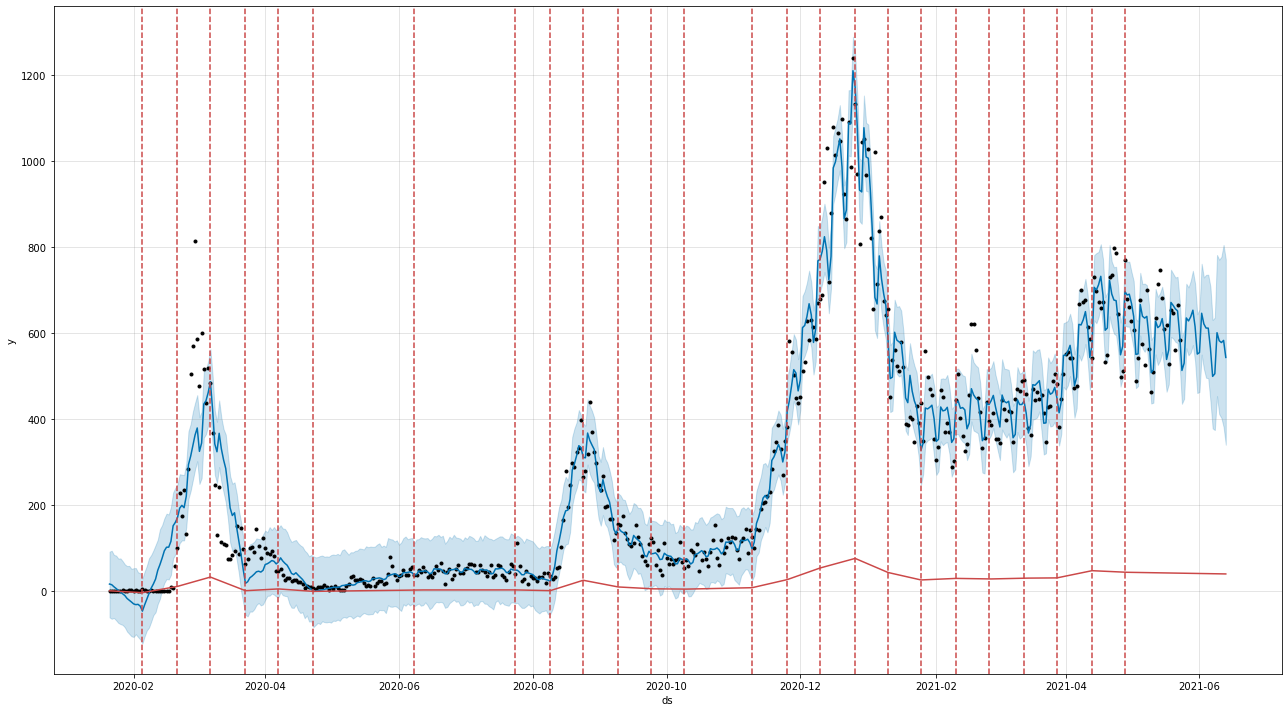

In [48]:
# display changepoints as red dotted line on the plot.
 
# changepoint를 그래프에 반영해봅시다.
fig = m.plot(forecast, figsize=(18, 10))
a = add_changepoints_to_plot(fig.gca(), m, forecast,cp_color='#cb4848')#cp_color=rgba hex or Matplotlib named color
 
#빨간색 점선 부분은 변곡(변화)이 발생한 부분이고 빨간색 실선은 추세(Trend)를 나타내는듯.
 
#그래프 파일 pdf로 다운 받기
'''
from google.colab import files
fig.savefig('output.pdf', format='pdf')
files.download('output.pdf')
'''

# 추세(트렌드)와 계절성 주기(패턴) 그래프
 
daily season은 False이므로 그려지지 않음

/Users/kwonseongjung/opt/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/kwonseongjung/opt/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/kwonseongjung/opt/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/kwonseongjung/opt/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



"\nfig2.savefig('trend_seasonality.pdf',format='pdf')\nfiles.download('trend_seasonality.pdf')\n"

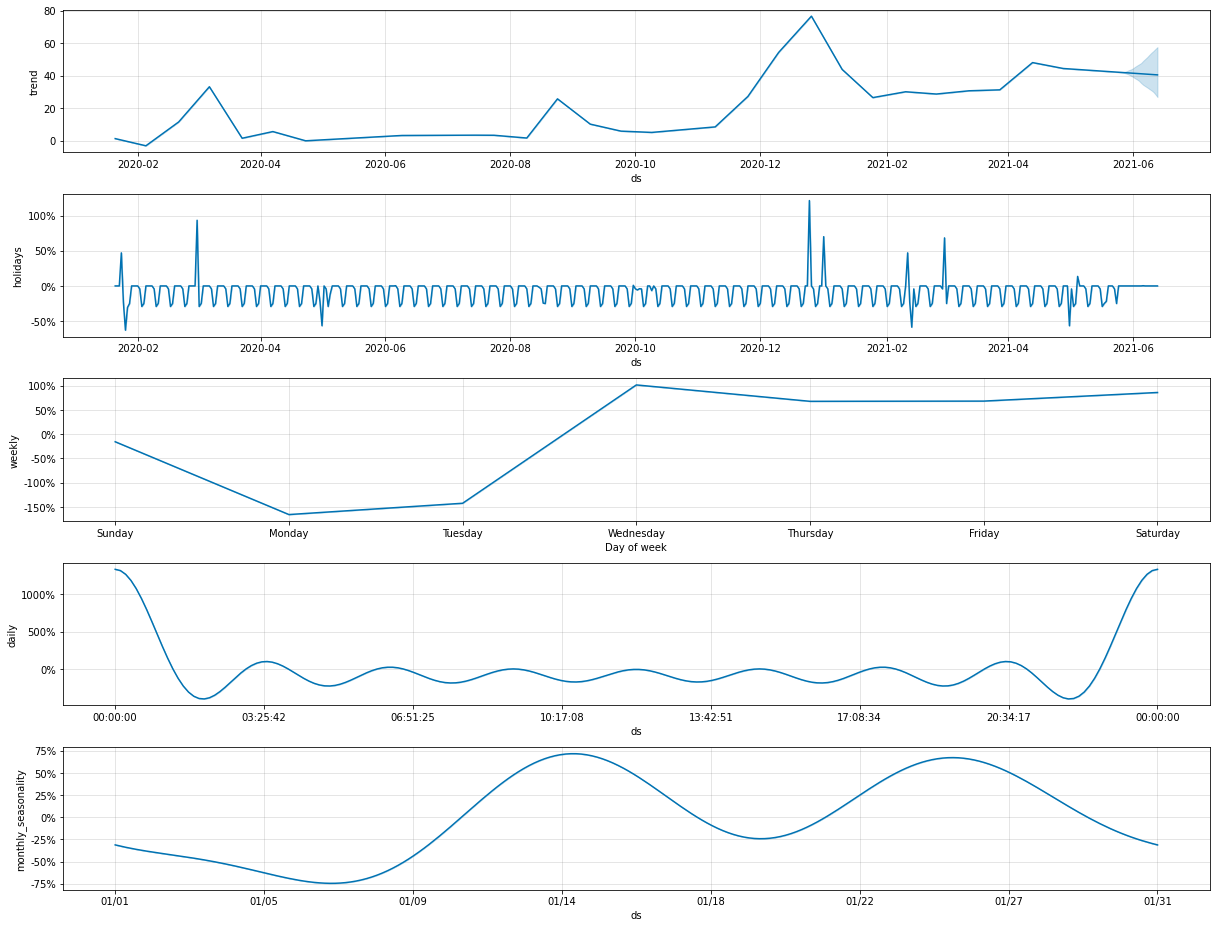

In [49]:
fig2 = m.plot_components(forecast, figsize=(17, 13))
#그래프 파일 pdf로 다운 받기
'''
fig2.savefig('trend_seasonality.pdf',format='pdf')
files.download('trend_seasonality.pdf')
'''

# 교차 검증(Cross validation)

[공식 Docs](https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation)

In [50]:
# Python
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m,horizon = '70 days')

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-09-20 00:00:00 and 2021-03-14 00:00:00
100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


In [51]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-21,62.081932,28.722693,91.625255,70,2020-09-20
1,2020-09-22,57.409347,24.435046,90.935008,61,2020-09-20
2,2020-09-23,65.417079,31.978392,99.799182,110,2020-09-20
3,2020-09-24,71.803823,30.979019,112.445862,125,2020-09-20
4,2020-09-25,81.617436,35.471618,128.877491,114,2020-09-20


In [52]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,2.011416e+04,141.824381,85.480645,0.206665,0.160168,0.571429
1,8 days,1.446414e+04,120.266961,79.409646,0.225112,0.221206,0.595238
2,9 days,1.471052e+04,121.286941,82.623665,0.270381,0.258861,0.595238
3,10 days,1.424209e+04,119.340244,84.042196,0.284037,0.258861,0.619048
4,11 days,1.148495e+04,107.167858,77.196314,0.278658,0.248530,0.642857
...,...,...,...,...,...,...,...
59,66 days,9.426313e+05,970.892024,841.065885,1.704466,1.304235,1.000000
60,67 days,9.719738e+05,985.887301,853.447351,1.713641,1.304235,1.000000
61,68 days,9.986006e+05,999.300030,860.980736,1.737876,1.304235,1.000000
62,69 days,1.018456e+06,1009.185655,867.295362,1.765433,1.304235,1.000000


In [53]:
#cutoff 날짜 별로 표 자르기
df_cv_seplist=[]

df_cv_sepr=df_cv
while(len(df_cv_sepr)>0):
  df_cv_sep=df_cv_sepr[df_cv_sepr.cutoff == df_cv_sepr.cutoff[df_cv_sepr.index[0]]]
  df_cv_seplist.append(df_cv_sep)
  df_cv_sepr=df_cv_sepr[df_cv_sepr.cutoff != df_cv_sepr.cutoff[df_cv_sepr.index[0]]]

In [54]:
import seaborn as sns #색상 파레트 가져오려고 부름
colors=sns.color_palette("husl",len(df_cv_seplist)+1)

fig_test= go.Figure()

fig_test.update_layout(
    title_text = 'Cross Validation Visualization(교차 검증 자료 시각화 그래프)',
    width=1000,
    height=800,
    xaxis = {'title': '날짜(ds)'},
    yaxis = {'title': '확진자수(명)(y)'}
)

fig_test.update_layout(
    width=1000,
    height=800
)

fig_test.add_trace(go.Scatter(x=df_prophet.ds, y=df_prophet.y,
                    mode='markers',
                    line_color='black',
                    name='실제 값'))

fig_test.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat,
                    mode='lines',
                    line_color='aqua',
                    name='예측'))

for i in range(len(df_cv_seplist)):
  #이게 불확실성 범위를 나타내는 그래프
  fig_test.add_trace(go.Scatter(
      x=df_cv_seplist[i].ds,
      y=df_cv_seplist[i].yhat_lower,
      showlegend=False,
      fill=None,
      mode='lines',
      line_color='rgba'+str(colors[i])[:-1]+',0)',
      name='yhat_lower'))

  fig_test.add_trace(go.Scatter(
      x=df_cv_seplist[i].ds,
      y=df_cv_seplist[i].yhat_upper,
      showlegend=False,
      fill="tonexty",
      mode='lines',
      line_color='rgba'+str(colors[i])[:-1]+',0)',
      name='yhat_upper'))

  fig_test.add_trace(go.Scatter(x=df_cv_seplist[i].ds, y=df_cv_seplist[i].yhat,
                      mode='lines+markers',
                      name=str(df_cv_seplist[i].reset_index(drop=True).ds[0].date()),
                      line_color='rgb'+str(colors[i])))

fig_test.show()

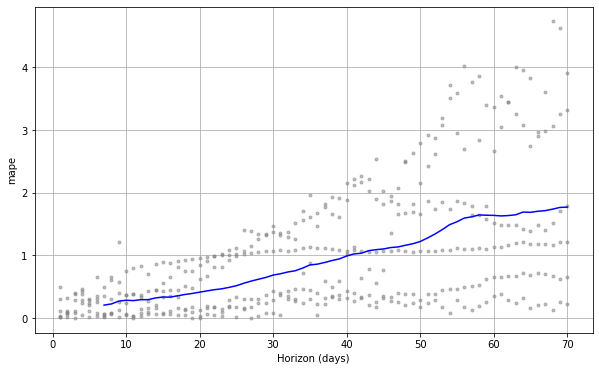

In [55]:
from fbprophet.plot import plot_cross_validation_metric
valid_fig = plot_cross_validation_metric(df_cv, metric='mape')
#horizen=118 일때 mape

In [56]:
#plotly로 시각화
#fbprophet의 plot.py에서 정의된 함수(plot_cross_validation_metric)의 내용을 수정해 다시 만든 것입니다.

def plotly_cross_validation_metrics(df_cv, metricinputs, rolling_window=0.1, figsize=(10, 6)):
    import seaborn as sns 
    colors=sns.color_palette("husl",len(df_p.columns)+1)

    df_p_fig=go.Figure()

    df_p_fig.update_layout(
    title_text = 'Cross Validation Metrics',
    width=figsize[0]*60,
    height=figsize[1]*60,
    xaxis = {'title': 'days'},
    yaxis = {'title': '%'})

    # Find the largest time resolution that has <1 unit per bin.
    dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
    dt_names = [
        'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
        'nanoseconds'
    ]
    dt_conversions = [
        24 * 60 * 60 * 10 ** 9,
        60 * 60 * 10 ** 9,
        60 * 10 ** 9,
        10 ** 9,
        10 ** 6,
        10 ** 3,
        1.,
    ]
    for metric in metricinputs:
      df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)
      df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)
      tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.

      for i, dt in enumerate(dts):
          if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
              break
      x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
      x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
      df_p_fig.add_trace(go.Scatter(x=x_plt, y=df_none[metric],
                        mode='markers',
                        name=metric+"_dots",
                        line_color='gray'))

      df_p_fig.add_trace(go.Scatter(x=x_plt_h, y=df_h[metric],
                      mode='lines+markers',
                      name=metricinputs[metricinputs.index(metric)]+"_line",
                      line_color='rgb'+str(colors[metricinputs.index(metric)])))

    return df_p_fig.show()

from fbprophet.plot import plot_cross_validation_metric
fig2 = plotly_cross_validation_metrics(df_cv, metricinputs=['mse', 'rmse', 'mae', 'mape','mdape'],rolling_window=0.1,figsize=(15, 10))


In [57]:
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.colors import n_colors
pan_w , pan_h = (1200,1000)


fig_future = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.003,
    specs=[[{"type": "table"}],
           [{"type": "scatter"}]]
)


future_df = forecast[['ds','yhat','yhat_lower','yhat_upper',"trend"]][len(df_prophet):]
reds = n_colors('rgb(255, 200, 255)', 'rgb(200, 0, 0)', int(max(max(future_df.yhat),max(df_prophet.y))+2), colortype='rgb')

fig_future.update_layout(
    title_text = '코로나 확진자 예측판: 근 {days}일간의 확진자 명수와 추이를 예측합니다.'.format(days=str(len(future_df))),
    font=dict(color='black', size=14),
    width=pan_w,
    height=pan_h,
    yaxis = {'title': '확진자수(명)'},
    xaxis = {'title': '날짜'}
)

fig_future.add_trace(go.Scatter(
    x=future_df.ds,
    y=future_df.yhat_lower,
    showlegend=True,
    fill=None,
    mode='lines',
    line_color='skyblue',
    name='yhat_lower'
))

fig_future.add_trace(go.Scatter(
    x=future_df.ds,
    y=future_df.yhat_upper,
    showlegend=True,
    fill="tonexty",
    mode='lines',
    line_color='skyblue',
    name='yhat_upper'
))


fig_future.add_trace(go.Scatter(x=future_df.ds, y=future_df.yhat,
                    mode='lines+markers',
                    name='확진자 예측치'))
'''
fig_future.add_trace(go.Scatter(x=future_df.ds, y=future_df.trend,
                    mode='lines',
                    name='trend'))
'''

future_df['ds']=future_df['ds'].astype(str)
future_df[['yhat','yhat_lower','yhat_upper']]=future_df[['yhat','yhat_lower','yhat_upper']].astype(int)

future_df = future_df.rename(
    columns={
    'ds':'년도-월-일',
    'yhat': '예측치(명)',
    'yhat_lower': '예상 최저치',
    'yhat_upper': '예상 최대치'}
    )

fig_future.add_trace(go.Table(  #표 만들기
    columnwidth = [90,90,90,90,110],
    header=dict(values=list(future_df),
                line_color=['gray','purple','skyblue','skyblue','gray'],
                fill_color=['gray','purple','skyblue','skyblue','gray'],
                align='center',font=dict(color='white', size=15),
                height=40),
    cells=dict(values=future_df.T,
               line_color=[["white"]*100,np.array(reds)[list(future_df["예측치(명)"])][:-1],"white"],
               fill_color=[["lightgray","white"]*len(future_df),np.array(reds)[list(future_df["예측치(명)"])][:],["lightgray","white"]*len(future_df)],
               align='center',font=dict(color='black', size=14),
               height=40)),row=1,col=1)

fig_future.show()
